In [1]:
import html
import json
import re
import nltk
import gensim

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from pathlib import Path
from sklearn.neighbors import KDTree
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction import DictVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans, KMeans, DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples
from scipy import sparse
from collections import Counter, defaultdict
from sklearn.pipeline import make_union, make_pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder
from pymystem3 import Mystem
from collections import Counter
from nltk.corpus import stopwords

sns.set()

%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 8)
pd.options.display.float_format = '{:.2f}'.format

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
fn = 'orders.csv'

In [3]:
lemmatized_words_file, lemmatized_words_freqs_file = Path("lemmatized.json"), Path("lemmatized_freqs.json")

In [4]:
original = pd.read_csv(fn)

In [5]:
dupes = sum(original.duplicated())
if dupes:
    original.drop_duplicates(inplace = True)
    print("Dropped {} duplicates".format(dupes))

Dropped 10 duplicates


# 1. Провести EDA
Просмотреть структуру данных, значения каждого признака, поискать особенности в признаках и в данных вцелом

In [6]:
eda = original.copy()

In [7]:
eda.head()

,DISCOUNT_VALUE,NAME,PRICE,QUANTITY,date_insert,discount,itemID,orderID,ordered_item_count,price,user_id
0,23.55%,Хроники Амбера. Том 2,357.00,1,2017-03-19 22:25:20,110.00,169108,602051,1,527.00,911531
1,4.07%,Хроники Амбера. Том 1,448.00,1,2017-03-19 22:19:58,19.00,1394744,602047,1,618.00,911531
2,4.17%,Пищеводитель,414.00,1,2017-03-19 20:58:00,65.00,191276,602017,4,1503.00,911587
3,4.17%,Аудиокн. Мясников. &quot;Ржавчина&quot;: что д...,253.00,1,2017-03-19 20:58:00,65.00,157945,602017,4,1503.00,911587
4,4.09%,Инфекции. Как защитить себя и своего ребенка,422.00,1,2017-03-19 20:58:00,65.00,205173,602017,4,1503.00,911587


In [8]:
eda.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 557808 entries, 0 to 557817
Data columns (total 11 columns):
DISCOUNT_VALUE        553771 non-null object
NAME                  557801 non-null object
PRICE                 557808 non-null float64
QUANTITY              557808 non-null int64
date_insert           557808 non-null object
discount              557808 non-null float64
itemID                557808 non-null int64
orderID               557808 non-null int64
ordered_item_count    557808 non-null int64
price                 557808 non-null float64
user_id               557808 non-null int64
dtypes: float64(3), int64(5), object(3)
memory usage: 51.1+ MB


**DISCOUNT_VALUE**: a discount percentage, applied to **PRICE** if <100%
**NAME**: an item's name  
**PRICE**: item's price with **DISCOUNT_VALUE** subtracted if it <100%  
**QUANTITY**: a number of items purchased  
**date_insert**: a date of purchase  
**discount**: an absolute value of discount, subtracted from a **price**  
**itemID**: an item identifier  
**orderID**: an order identifier  
**ordered_item_count**: a number of items in order  
**price**: a total price of order  
**user_id**: an user's identifier

##### DISCOUNT_VALUE

In [9]:
sum(eda.DISCOUNT_VALUE.isnull())

4037

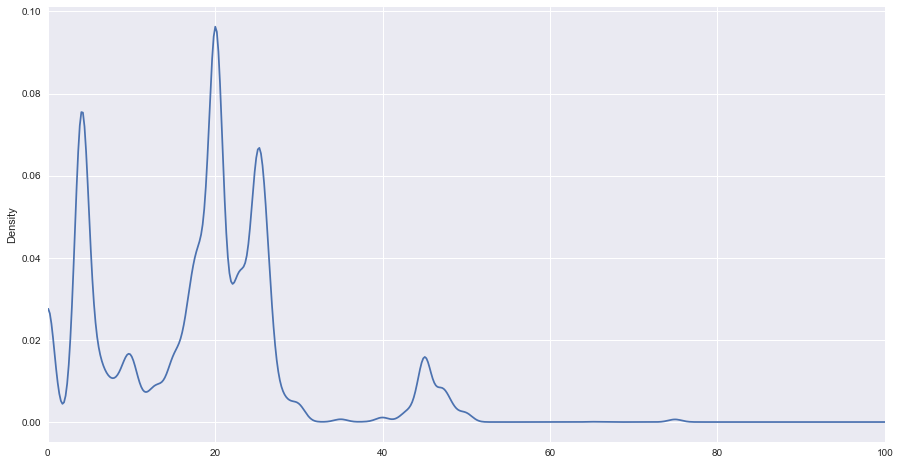

In [10]:
not_null_discounts = eda[eda.DISCOUNT_VALUE.notnull()].DISCOUNT_VALUE.apply(lambda x: float(str(x).replace("%", "")))
not_null_discounts.plot(kind="density", xlim=[0, 100])

Peaks at 0%, ~4%, ~20%, ~25% and ~45%.

##### NAME

In [11]:
sum(eda.NAME.isnull())

7

In [12]:
eda[eda.NAME.isnull()]

,DISCOUNT_VALUE,NAME,PRICE,QUANTITY,date_insert,discount,itemID,orderID,ordered_item_count,price,user_id
110107,NaN,NaN,11221.00,1,2017-04-27 09:15:19,0.00,132542,624656,1,11500.00,195867
146016,NaN,NaN,12587.00,1,2017-05-19 02:15:11,0.00,133342,634448,1,12866.00,195867
159453,NaN,NaN,12587.00,1,2017-05-23 11:15:12,0.00,133342,636646,1,12587.00,195867
160684,NaN,NaN,1625.00,1,2017-05-26 12:15:14,0.00,144934,639120,1,1625.00,195867
178111,NaN,NaN,1625.00,1,2017-05-29 09:15:12,0.00,144934,640360,1,1625.00,195867
200009,NaN,NaN,1625.00,1,2017-06-06 12:15:11,0.00,144934,645680,1,1625.00,195867
200772,NaN,NaN,1625.00,1,2017-06-09 06:15:14,0.00,144934,647375,1,1625.00,195867


In [13]:
len(eda[eda.itemID == 132542]) + len(eda[eda.itemID == 133342]) + len(eda[eda.itemID == 144934])

7

We have no means of restoring these items' names.

##### PRICE

In [14]:
sum(eda.PRICE.isnull())

0

Whew, no NaN prices.

In [15]:
len(eda.PRICE) - len(eda.PRICE.nonzero()[0])

903

But zero prices are here.

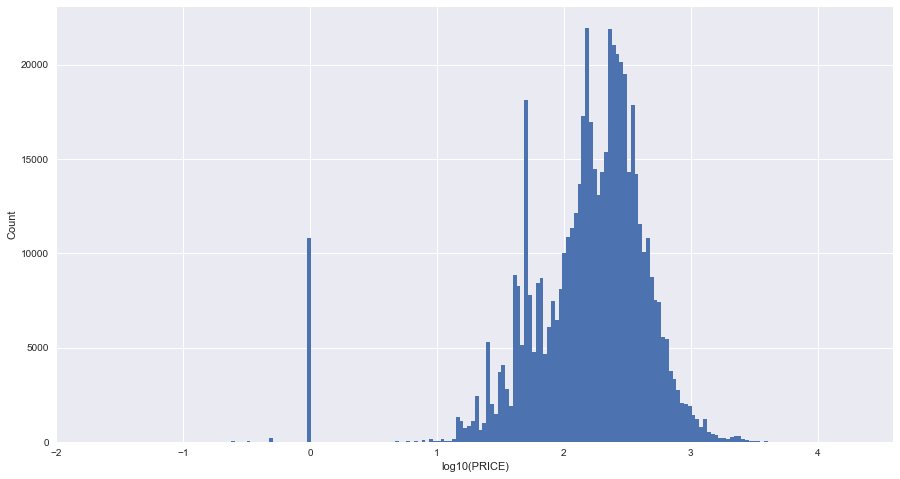

In [16]:
plot = np.log10(eda.PRICE.iloc[eda.PRICE.nonzero()[0]]).hist(bins=200)
plot.set_ylabel("Count")
plot.set_xlabel("log10(PRICE)")

Log-scaled PRICE distribution looks almost normal except for the huge outlier at 0.

In [17]:
len(eda[eda.PRICE < 10])

12601

##### QUANTITY

In [18]:
sum(eda.QUANTITY.isnull())

0

In [19]:
len(eda.QUANTITY) - len(eda.QUANTITY.nonzero()[0])

0

In [20]:
eda.QUANTITY.describe()

count   557808.00
mean         1.65
std          5.05
min          1.00
25%          1.00
50%          1.00
75%          1.00
max        500.00
Name: QUANTITY, dtype: float64

In [21]:
eda.QUANTITY.quantile(0.9)

1.0

In [22]:
eda.QUANTITY.quantile(0.99)

24.0

In [23]:
eda.QUANTITY.quantile(0.999)

54.0

Very skewed distribution.

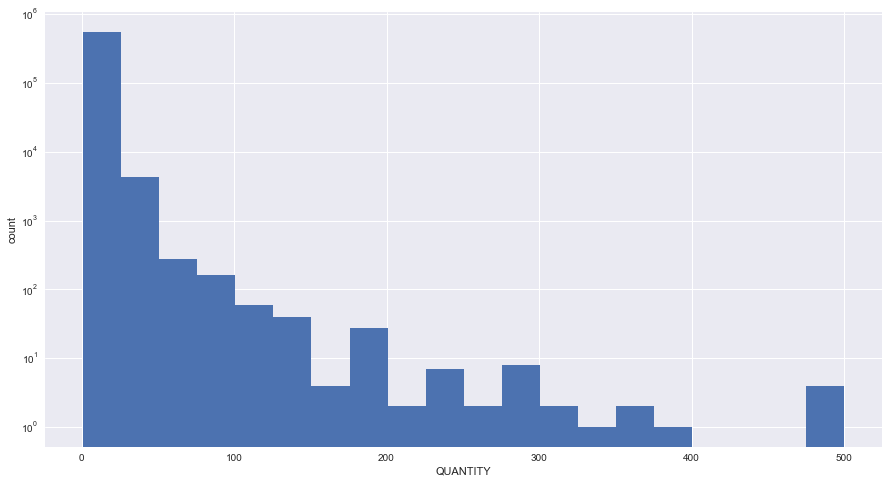

In [24]:
plot = eda.QUANTITY.hist(bins=20, log=True)
plot.set_xlabel("QUANTITY")
plot.set_ylabel("count")
plot

##### date_insert

In [25]:
sum(eda.date_insert.isnull())

0

In [26]:
dates = pd.to_datetime(eda.date_insert)

In [27]:
dates.max()

Timestamp('2017-10-01 23:50:02')

In [28]:
dates.min()

Timestamp('2017-03-13 00:05:06')

In [29]:
dates.max() - dates.min()

Timedelta('202 days 23:44:56')

##### itemID

In [30]:
sum(eda.itemID.isnull())

0

In [31]:
len(eda.itemID.unique())

51890

In [32]:
len(eda.itemID.unique()) - len(eda.NAME.unique())

-22743

More NAMEs than itemIDs, not good.

##### orderID

In [33]:
sum(eda.orderID.isnull())

0

In [34]:
len(eda.orderID.unique())

127683

##### ordered_item_count

In [35]:
sum(eda.ordered_item_count.isnull())

0

In [36]:
len(eda.ordered_item_count) - len(eda.ordered_item_count.nonzero()[0])

0

In [37]:
# effectively just extracting a number of items, price and user_id for each order
orders = eda.groupby("orderID").agg({"ordered_item_count": "mean", "price": "mean", "user_id": "mean"})

In [38]:
orders.ordered_item_count.describe()

count   127683.00
mean         4.37
std          5.83
min          1.00
25%          1.00
50%          3.00
75%          5.00
max        277.00
Name: ordered_item_count, dtype: float64

And again, very skewed.

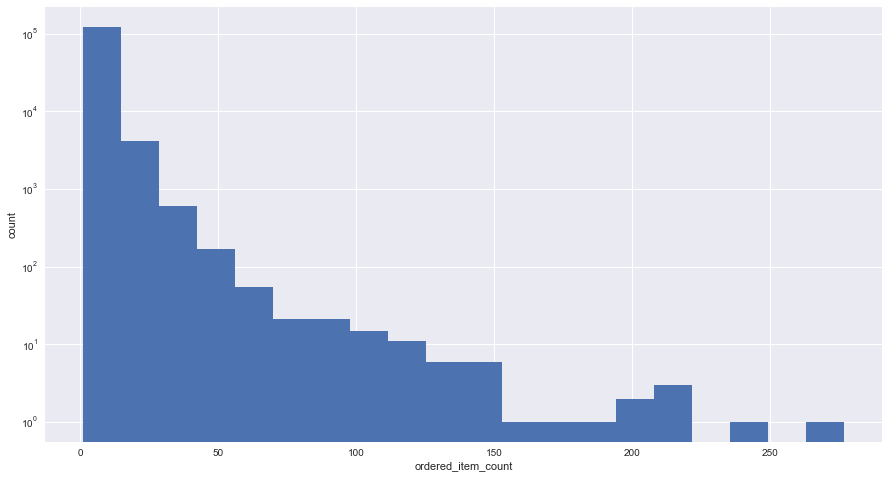

In [39]:
plot = orders.ordered_item_count.hist(bins=20, log=True)
plot.set_xlabel("ordered_item_count")
plot.set_ylabel("count")
plot

##### price

In [40]:
sum(eda.price.isnull())

0

In [41]:
len(eda.price) - len(eda.price.nonzero()[0])

0

In [42]:
# effectively just extracting a number of items, price and user_id for each order
orders = eda.groupby("orderID").agg({"ordered_item_count": "mean", "price": "mean", "user_id": "mean"})

In [43]:
orders.price.describe()

count   127683.00
mean      1666.75
std       4134.88
min          1.00
25%        660.00
50%       1088.00
75%       1551.00
max     386495.00
Name: price, dtype: float64

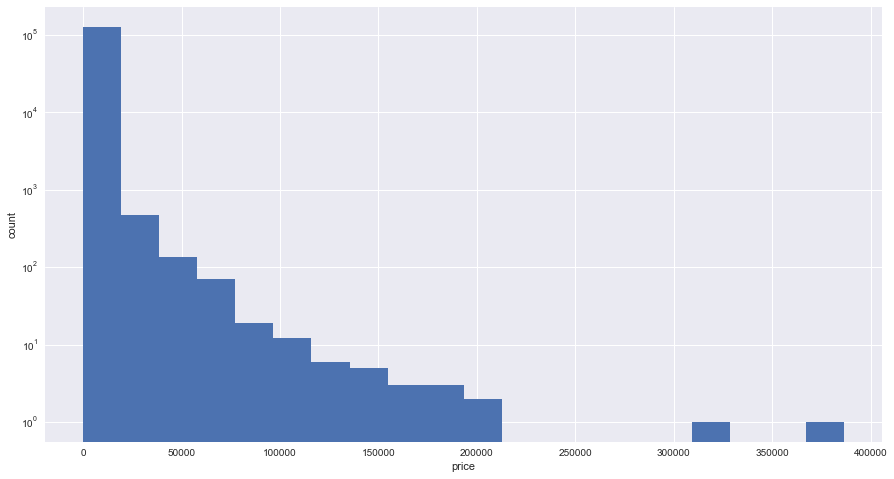

In [44]:
plot = orders.price.hist(bins=20, log=True)
plot.set_xlabel("price")
plot.set_ylabel("count")
plot

##### user_id

In [45]:
sum(eda.user_id.isnull())

0

In [46]:
len(eda.user_id.unique())

76258

In [47]:
# effectively just extracting a number of items, price and user_id for each order
orders = eda.groupby("orderID").agg({"ordered_item_count": "mean", "price": "mean", "user_id": "mean"})

In [48]:
orders_by_user = orders.groupby("user_id").sum()

In [49]:
orders_by_user.ordered_item_count.describe()

count   76258.00
mean        7.31
std        18.69
min         1.00
25%         1.00
50%         3.00
75%         7.00
max      2225.00
Name: ordered_item_count, dtype: float64

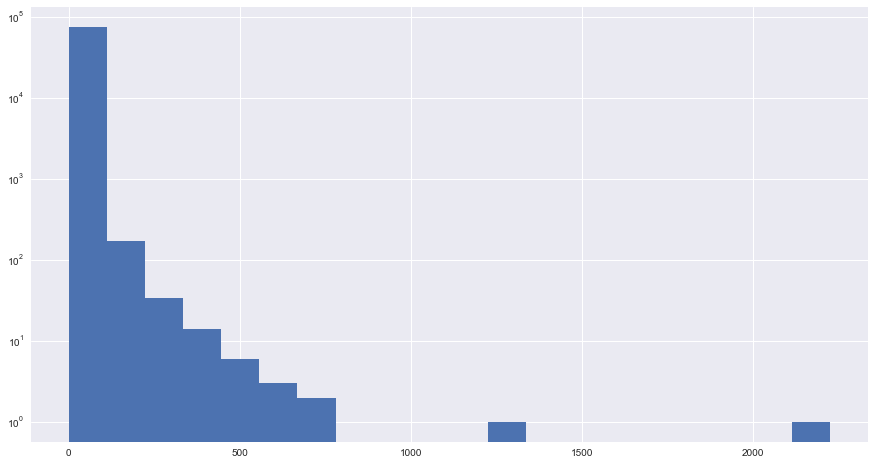

In [50]:
orders_by_user.ordered_item_count.hist(bins=20, log=True)

In [51]:
orders_by_user.price.describe()

count     76258.00
mean       2790.73
std       10422.42
min           1.00
25%         762.00
50%        1224.96
75%        2397.46
max     1344584.40
Name: price, dtype: float64

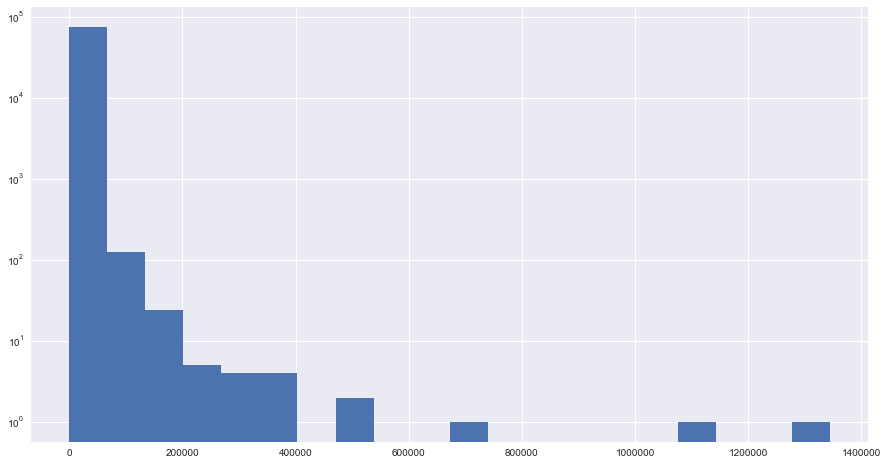

In [52]:
orders_by_user.price.hist(bins=20, log=True)

##### Overall

In [53]:
order_602051 = eda[eda.orderID == 602051].copy()
eda[eda.orderID == 602051]

,DISCOUNT_VALUE,NAME,PRICE,QUANTITY,date_insert,discount,itemID,orderID,ordered_item_count,price,user_id
0,23.55%,Хроники Амбера. Том 2,357.00,1,2017-03-19 22:25:20,110.00,169108,602051,1,527.00,911531


In [54]:
order_602051["total"] = order_602051.PRICE * order_602051.QUANTITY
order_602051

,DISCOUNT_VALUE,NAME,PRICE,QUANTITY,date_insert,discount,itemID,orderID,ordered_item_count,price,user_id,total
0,23.55%,Хроники Амбера. Том 2,357.00,1,2017-03-19 22:25:20,110.00,169108,602051,1,527.00,911531,357.00


In [55]:
agg_order = order_602051.groupby("orderID").agg({"total": "sum", "price": "mean"})
agg_order.price - agg_order.total # why?

orderID
602051   170.00
dtype: float64

In [56]:
sum(eda.discount < 0) # why?

290

In [57]:
eda[eda.orderID == 724930] # what?

,DISCOUNT_VALUE,NAME,PRICE,QUANTITY,date_insert,discount,itemID,orderID,ordered_item_count,price,user_id
555980,4.03%,Мой лучший друг - желудок : еда для умных людей,400.35,1,2017-09-25 20:09:52,237.60,1441562,724930,5,1346.40,969687
555981,22.9%,Замерзшие. 5 месяцев в снегах Гренландии,181.90,1,2017-09-25 20:09:52,237.60,665796,724930,5,1346.40,969687
555982,18.15%,Hygge. Рецепты уютной жизни по-скандинавски,266.90,1,2017-09-25 20:09:52,237.60,1603980,724930,5,1346.40,969687
555983,18.01%,"Дрейф. Вдохновляющая история изобретателя, пот...",273.70,1,2017-09-25 20:09:52,237.60,219629,724930,5,1346.40,969687
555984,NaN,Куриный бульон для души: 101 история о чудесах,223.55,1,2017-09-25 20:09:52,237.60,1574300,724930,5,1346.40,969687


In [58]:
eda[eda.orderID == 729426] # whaaat?

,DISCOUNT_VALUE,NAME,PRICE,QUANTITY,date_insert,discount,itemID,orderID,ordered_item_count,price,user_id
556997,NaN,Негоже лилиям прясть,319.60,2,2017-09-30 12:35:45,401.85,1623401,729426,7,2916.35,216650
556998,NaN,Стихотворения. Поэмы,359.55,1,2017-09-30 12:35:45,401.85,1603446,729426,7,2916.35,216650
556999,NaN,Сравнительные жизнеописания,319.60,1,2017-09-30 12:35:45,401.85,1424444,729426,7,2916.35,216650
557000,13.03%,Узница Шато-Гайара,319.60,1,2017-09-30 12:35:45,401.85,1407019,729426,7,2916.35,216650
557001,13.03%,Яд и корона,319.60,1,2017-09-30 12:35:45,401.85,1574167,729426,7,2916.35,216650
557002,13.03%,Железный король,319.60,1,2017-09-30 12:35:45,401.85,728743,729426,7,2916.35,216650
557003,NaN,Французская волчица,319.60,2,2017-09-30 12:35:45,401.85,1645350,729426,7,2916.35,216650


# 2. Спланировать эксперимент 

Задача:
* сегментация товаров + сегментация пользователей (по товарам, по поведению, скидкам и пр.)

Дополнительнительные задачи (опционально, подумайте о них, могут появиться интересные идеи и находки):
* поиск товаров-заменителей и товаров, дополняющих друг друга
* поиск выбросов среди товаров
* поиск выбросов среди заказов

Эксперимент - составить план, по которому будет проделана исследовательская работа. Примерные пункты плана:
* Составить первичный список признаков, необходимых для решения задачи
* Сгенерировать список новых признаков, которые можно получить из данных
* Применить понижение размерности для визуализации данных
* Применить кластеризацию, визуализировать
* Описание кластера
* Любые другие пункты

Two stages:
1. Clusterize items  
  a. Since there's not much information about items, we can use only PRICE and NAME from the original dataset; however, prices tend to change over time, so PRICE is irrelevant here   
  b. NAME isn't very helpful as it is, we need to convert it to a bag of words OR some other vector representation  
  c. Extract the most significant words with PCA 
  d. Compare different clustering algorithms
2. Clusterize customers by the items they buy
  a. Assign a most common cluster label from all customer's books to this customer.
  b. Extract new features

# 3. Выполнить подготовку данных для построения модели

Выполнить необходимые преобразования данных

### Part 1: items

1. Get rid of weight, quotes, `&quot;` and everything that isn't a word
2. Tokenize titles
3. Stem tokens
4. Prepare data points with different dimensions and nature: BoW, PCA(BoW), Word2vec, PCA(Word2vec)

In [59]:
def clean_names(data):
    regex_words = re.compile("[\W]+")
    regex_weight = re.compile(" вес \d+.*")
    regex_numbers = re.compile("[0-9]+")

    def clean(s):
        s = s.lower()
        s = html.unescape(s)
        s = regex_words.sub(" ", s, re.U).strip()
        s = regex_weight.sub("", s, re.U)
        s = regex_numbers.sub("", s, re.U)
        s = regex_words.sub(" ", s, re.U).strip()
        return s
    
    return data.NAME.replace(np.nan, "").apply(clean)

In [60]:
def get_unique_clean_names(data):
    return pd.DataFrame(data.clean_name.unique(), columns=["clean_name"])

In [61]:
def get_tokenized_clean_names(sentences, lemmatize_words):
    if lemmatize_words:
        lemmatizer = Mystem()

    def lemmatize(s):
        return [x for x in lemmatizer.lemmatize(s) if x != " " and x != "\n"]
    
    docs = []
    word_count = Counter()
    russian_stopwords = stopwords.words("russian")
    english_stopwords = stopwords.words("english")
    for s in sentences:
        tokens = [x for x in lemmatize(s) if len(x) > 1] if lemmatize_words else s.split()
        tokens = [x for x in tokens if x not in russian_stopwords and x not in english_stopwords]
        docs.append(Counter(tokens))
        for t in tokens:
            word_count[t] += 1
    
    return (docs, word_count)

In [62]:
def get_top_n_words(docs, word_count, n):
    top = dict(word_count.most_common(n))
    return [{k: v for k, v in d.items() if k in top} for d in docs]

We have forking paths here.  
DBSCAN is fine with high-dimensional data (slow, but viable), but K-means becomes a memory hog as dimensions grow.  
The one solution is to prepare two training datasets, one full and one processed with PCA.

In [63]:
def get_bag_of_words(docs):
    pipeline = Pipeline([
        ("vect", DictVectorizer(sparse=False)),
    ])
    return pipeline.fit_transform(docs)

And now for something completely different. Because why not. 

In [64]:
def get_w2v_vecs(docs):
    # https://nlpub.ru/Russian_Distributional_Thesaurus
    w2v_fpath = "tenth.norm-sz500-w7-cb0-it5-min5.w2v"
    w2v = gensim.models.KeyedVectors.load_word2vec_format(w2v_fpath, binary=True, unicode_errors='ignore')
    w2v.init_sims(replace=True)  
    vecs = []
    for c in docs:
        s, n = 0, 0
        for w in c:
            s += w2v.word_vec(w, use_norm=True) if w in w2v.vocab else np.zeros(500)
            n += 1
        if n < 1:
            vecs.append(np.zeros(500))
            continue
        vecs.append(s / n)
    del w2v # we'll need all this RAM later
    return np.array(vecs).ravel().reshape(-1, 500)

In [65]:
def reduce_dims(points, n):
    return PCA(n_components=n).fit_transform(points)

### Part 2: users

1. Restore NaN DISCOUNT_VALUE values
2. Convert DISCOUNT_VALUE to float
3. Group by user_id
4. New feature — orders_count — a total number
5. New feature — mean_rows_per_order — a mean number of types of books per customer's order
6. New feature — mean_items_per_order — a mean number of books per customer's order
7. New feature — total_items — a total number of books in all customer's orders
8. New feature — mean_price_per_order — a mean price of customer's order
9. New feature — total_price — a total price of all customer's orders
10. New feature — mean_delta_per_order — a mean difference between true price and discounted price of an order
11. New feature — total_delta — a total difference between true price and discounted price of all customer's orders
12. New feature — mean_service_fee_per_order — a mean difference between a sum of prices of all items in an order and a price of an order
13. New feature — total_service_fee — a total difference between a sum of prices of all items in customer's orders and a sum of prices of all customer's orders

In [66]:
# ugly and slow, but gets the job done
def prepare_users_data(data):
    orders = []
    for g in data.groupby("user_id"):
        rows_per_order = {}
        items_per_order = defaultdict(int)
        full_price_per_order = defaultdict(float)
        true_price_per_order = defaultdict(float)
        delta_for_order = defaultdict(float)
        price_per_order = {}
        for r in g[1].iterrows():
            row = r[1]
            if row.orderID not in rows_per_order:
                rows_per_order[row.orderID] = row.ordered_item_count
            if row.orderID not in price_per_order:
                price_per_order[row.orderID] = row.price
                
            items_per_order[row.orderID] += row.QUANTITY
            full_price_per_order[row.orderID] += row.PRICE * row.QUANTITY
            true_price_per_order[row.orderID] += row.true_price * row.QUANTITY
            delta_for_order[row.orderID] += row.price_delta
        
        orders_count = len(rows_per_order)
        mean_rows_per_order = sum(rows_per_order.values()) / orders_count
        total_items = sum(items_per_order.values())
        mean_items_per_order = total_items / orders_count
        total_price = sum(full_price_per_order.values())
        mean_price_per_order = total_price / orders_count
        total_delta = sum(delta_for_order.values())
        mean_delta_per_order = total_delta / orders_count
        total_service_fee = sum([price_per_order[k] - full_price_per_order[k] for k in items_per_order]) 
        mean_service_fee_per_order = total_service_fee / orders_count
                     
        orders.append((g[0], orders_count, 
                       mean_rows_per_order, 
                       mean_items_per_order, total_items, 
                       mean_price_per_order, total_price, 
                       mean_delta_per_order, total_delta, 
                       mean_service_fee_per_order, total_service_fee))
        
    orders_df = pd.DataFrame(orders, columns=["user_id", 
                                              "orders_count", 
                                              "mean_rows_per_order", 
                                              "mean_items_per_order", "total_items", 
                                              "mean_price_per_order", "total_price", 
                                              "mean_delta_per_order", "total_delta", 
                                              "mean_service_fee_per_order", "total_service_fee"])
    orders_df = orders_df.set_index(["user_id"])
    return orders_df

In [67]:
def prepare_data(data, clusters):
    df = data.copy()
    df["DISCOUNT_VALUE"] = df.DISCOUNT_VALUE.fillna("100%").apply(lambda x: float(x.strip("%")) / 100)
    df["true_price"] = df.apply(lambda x: x.PRICE / (1 - x.DISCOUNT_VALUE + bool(x.DISCOUNT_VALUE == 1)), axis=1)
    df["price_delta"] = df.apply(lambda x: abs(x.PRICE * bool(x.DISCOUNT_VALUE != 1) - x.true_price), axis=1)
    df = pd.merge(left=df, right=clusters, on="clean_name")
    users_data = prepare_users_data(df)
    # using the most common cluster across all user's books
    users_with_most_common_cluster = df.groupby(["user_id"]).agg({"cluster": lambda x: x.value_counts().index[0]})
    combined = pd.merge(left=users_with_most_common_cluster, right=users_data, left_index=True, right_index=True)
        
    def get_num_cols(X):
        return X[["orders_count", 
                  "mean_rows_per_order", 
                  "mean_items_per_order", 
                  "total_items", 
                  "mean_price_per_order", 
                  "total_price", 
                  "mean_delta_per_order", 
                  "total_delta", 
                  "mean_service_fee_per_order", 
                  "total_service_fee"
                 ]]
    def get_cluster_col(X):
        return X[["cluster"]]
    
    pipeline = make_union(*[
        make_pipeline(FunctionTransformer(get_num_cols, validate=False), StandardScaler()),
        make_pipeline(FunctionTransformer(get_cluster_col, validate=False), OneHotEncoder(sparse=False))        
    ])
    return (combined, pipeline.fit_transform(combined))

# 4. Провести построение модели 

In [68]:
d = original.copy()

In [69]:
d["clean_name"] = clean_names(d)

In [70]:
unique_names = get_unique_clean_names(d)

In [71]:
tokenized_names, tokenized_word_counts = get_tokenized_clean_names(unique_names.clean_name, False)

In [73]:
if lemmatized_words_file.exists() and lemmatized_words_freqs_file.exists():
    lemmatized_names = json.load(lemmatized_words_file.open(mode="r", encoding="utf-8"))
    lemmatized_word_counts = json.load(lemmatized_words_freqs_file.open(mode="r", encoding="utf-8"))
else:
    lemmatized_names, lemmatized_word_counts = get_tokenized_clean_names(unique_names.clean_name, True)
    json.dump(lemmatized_names, lemmatized_words_file.open(mode="w", encoding="utf-8"))
    json.dump(lemmatized_word_counts, lemmatized_words_freqs_file.open(mode="w", encoding="utf-8"))

In [74]:
top_500 = get_top_n_words(lemmatized_names, Counter(lemmatized_word_counts), 500)

In [75]:
bag_of_words = get_bag_of_words(top_500)
reduced_bag_of_words = reduce_dims(bag_of_words, 0.75)

In [76]:
bag_of_words.shape, reduced_bag_of_words.shape

((42056, 500), (42056, 207))

In [77]:
w2v_points = get_w2v_vecs(tokenized_names)
reduced_w2v_points = reduce_dims(w2v_points, 0.75)

In [78]:
w2v_points.shape, reduced_w2v_points.shape

((42056, 500), (42056, 193))

In [79]:
def mean_sorted_dist_for_n_neighbours(X, n):
        tree = KDTree(X)
        return sorted([tree.query([row], k=n+1)[0][0][1:].mean() for row in X])

In [80]:
def plot_elbow(points, title):
    plt.figure(figsize=(20, 10))
    plt.xlabel("sorted distances over all pairs")
    plt.ylabel('mean dist over n nearest neighbors')
    
    x = list(range(1, points.shape[0] + 1))
    
    for min_pts in list(range(1, 10)):
        distances = mean_sorted_dist_for_n_neighbours(points, min_pts)
        plt.plot(x, distances, label="min_pts = {}".format(min_pts))
        
    plt.title(title)
    plt.grid()
    plt.legend()
    plt.show()

In [81]:
def plot_kmeans_stats(data, n, title):
    inertias = []
    silhs = []
    for n_clusters in range(3, n):        
        kmeans = KMeans(random_state=0, max_iter=100, init='k-means++', n_clusters=n_clusters)
        kmeans.fit(data)
        clusters = kmeans.predict(data)
        silhouette_avg = silhouette_score(data, clusters)
        
        print("For n_clusters =", n_clusters, 
              "The inertia_ is :", kmeans.inertia_, 
              "The average silhouette_score is :", silhouette_avg)
        
        inertias.append(kmeans.inertia_)
        silhs.append(silhouette_avg)
    plt.title(title)
    plt.plot(range(3, n), inertias)
    plt.plot(range(3, n), silhs)

For n_clusters = 3 The inertia_ is : 61134.7323121 The average silhouette_score is : 0.27477964112
For n_clusters = 4 The inertia_ is : 60476.4839841 The average silhouette_score is : 0.187076572652
For n_clusters = 5 The inertia_ is : 59830.399707 The average silhouette_score is : 0.317726036501
For n_clusters = 6 The inertia_ is : 58778.2627941 The average silhouette_score is : 0.237653134538
For n_clusters = 7 The inertia_ is : 57572.2899933 The average silhouette_score is : 0.189156400659
For n_clusters = 8 The inertia_ is : 57220.3468773 The average silhouette_score is : 0.277714874592
For n_clusters = 9 The inertia_ is : 56770.5243895 The average silhouette_score is : 0.246818740043
For n_clusters = 10 The inertia_ is : 56431.4246288 The average silhouette_score is : 0.255210041445
For n_clusters = 11 The inertia_ is : 55340.70326 The average silhouette_score is : 0.204299510316
For n_clusters = 12 The inertia_ is : 54662.5910117 The average silhouette_score is : 0.227701929088
F

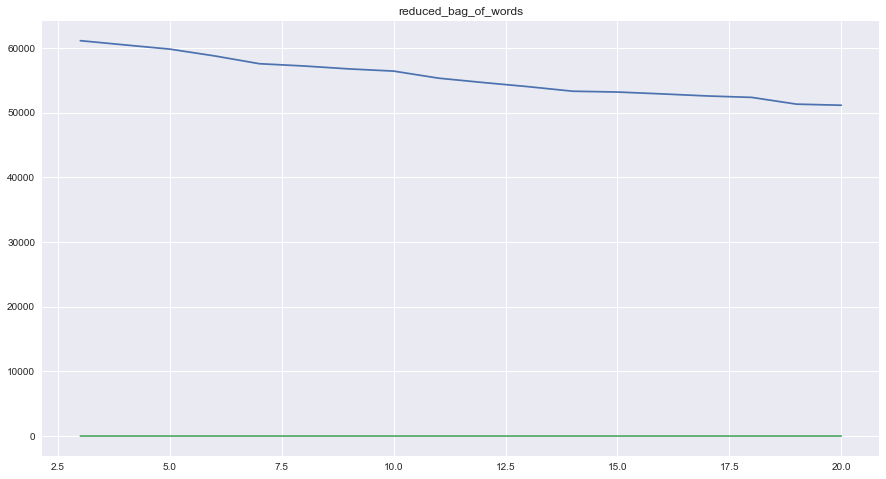

In [82]:
plot_kmeans_stats(reduced_bag_of_words, 21, "reduced_bag_of_words")

Silhouette isn't bad, but inertia is quite large.

For n_clusters = 3 The inertia_ is : 9919.21849314 The average silhouette_score is : 0.0327319330024
For n_clusters = 4 The inertia_ is : 9764.18526633 The average silhouette_score is : 0.0293834107764
For n_clusters = 5 The inertia_ is : 9627.89791013 The average silhouette_score is : 0.0164184707284
For n_clusters = 6 The inertia_ is : 9519.13129099 The average silhouette_score is : 0.018233597797
For n_clusters = 7 The inertia_ is : 9417.0106333 The average silhouette_score is : 0.0211141169147
For n_clusters = 8 The inertia_ is : 9324.50782339 The average silhouette_score is : 0.0194123798754
For n_clusters = 9 The inertia_ is : 9240.97009844 The average silhouette_score is : 0.0151844110941
For n_clusters = 10 The inertia_ is : 9162.35335813 The average silhouette_score is : 0.0159233105975
For n_clusters = 11 The inertia_ is : 9096.40053612 The average silhouette_score is : 0.0151874697751
For n_clusters = 12 The inertia_ is : 9027.31466867 The average silhouette_score is : 0.012

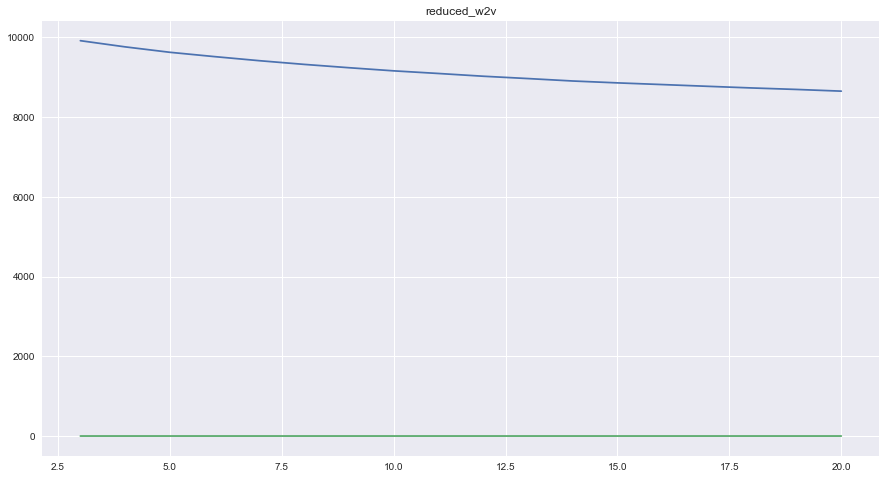

In [83]:
plot_kmeans_stats(reduced_w2v_points, 21, "reduced_w2v")

Looks like w2v points with reduced dimensions is a good trade-off. Alas, no "elbows" on either of plots.
  
Let's check if we can use DBSCAN.

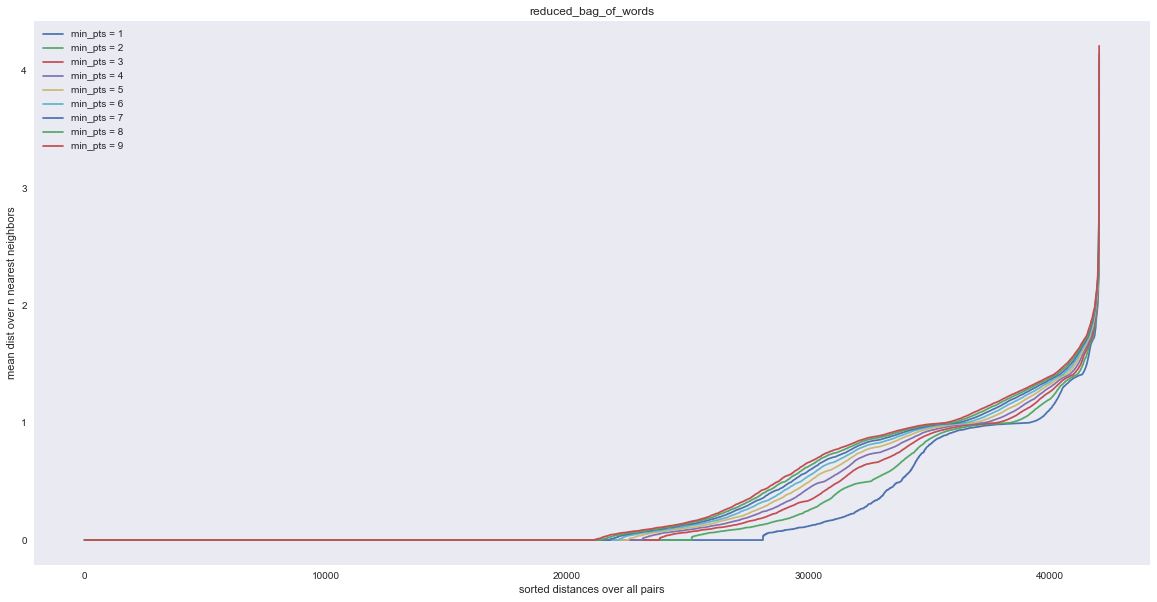

In [84]:
plot_elbow(reduced_bag_of_words, "reduced_bag_of_words")

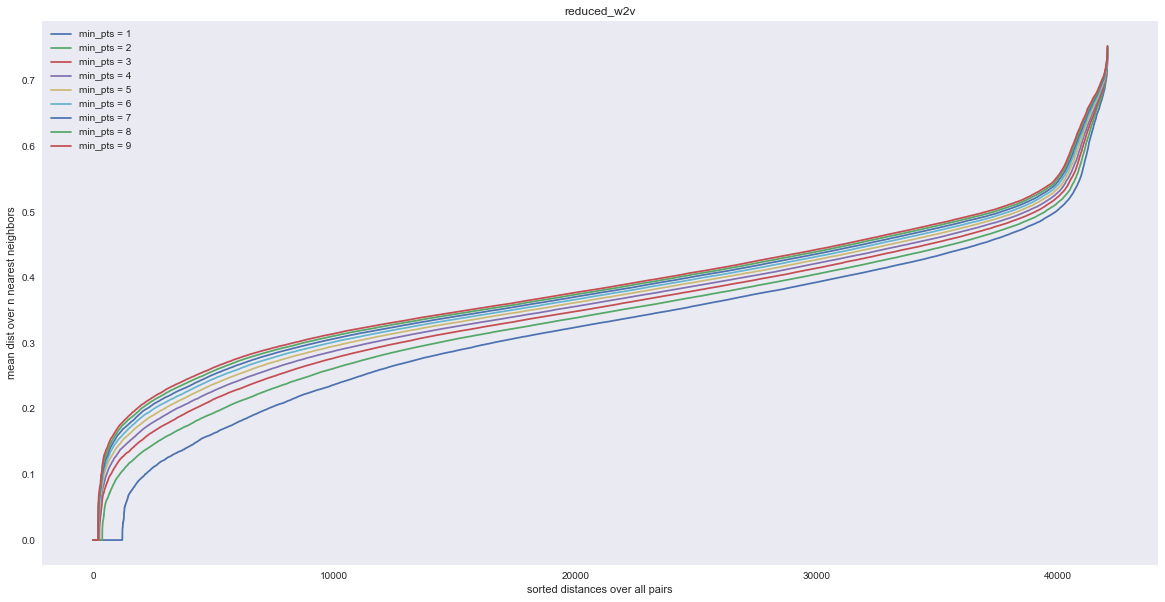

In [85]:
plot_elbow(reduced_w2v_points, "reduced_w2v")

 W2v points yield funny plots with two (!) "elbows".
 
 Let's compare K-means and DBSCAN.

In [86]:
km_clusters = KMeans(random_state=0, init="k-means++",  n_clusters=20).fit_predict(reduced_w2v_points)
Counter(km_clusters)

Counter({0: 1523,
         1: 1449,
         2: 2615,
         3: 2431,
         4: 1228,
         5: 1382,
         6: 2262,
         7: 3792,
         8: 3499,
         9: 1765,
         10: 1552,
         11: 3075,
         12: 2457,
         13: 1425,
         14: 2112,
         15: 2248,
         16: 1572,
         17: 2237,
         18: 1333,
         19: 2099})

In [87]:
db_bow_clusters = DBSCAN(eps=2, min_samples=3, n_jobs=8).fit_predict(reduced_bag_of_words)
Counter(db_bow_clusters)

Counter({-1: 72, 0: 41971, 1: 7, 2: 6})

Too skewed.

In [88]:
db_w2v_clusters = DBSCAN(eps=0.25, min_samples=3, n_jobs=-1).fit_predict(reduced_w2v_points)
Counter(db_w2v_clusters)

Counter({-1: 34140,
         0: 214,
         1: 2521,
         2: 3,
         3: 5,
         4: 4,
         5: 3,
         6: 42,
         7: 5,
         8: 14,
         9: 4,
         10: 31,
         11: 3,
         12: 4,
         13: 5,
         14: 5,
         15: 3,
         16: 3,
         17: 5,
         18: 4,
         19: 3,
         20: 5,
         21: 3,
         22: 6,
         23: 11,
         24: 3,
         25: 4,
         26: 13,
         27: 4,
         28: 8,
         29: 4,
         30: 19,
         31: 7,
         32: 7,
         33: 4,
         34: 5,
         35: 5,
         36: 7,
         37: 205,
         38: 3,
         39: 26,
         40: 5,
         41: 25,
         42: 70,
         43: 10,
         44: 4,
         45: 446,
         46: 5,
         47: 3,
         48: 7,
         49: 8,
         50: 35,
         51: 3,
         52: 8,
         53: 3,
         54: 3,
         55: 3,
         56: 3,
         57: 6,
         58: 26,
         59: 14,
        

Very much noise, let's try second "elbow".

In [89]:
db_w2v_clusters = DBSCAN(eps=0.7, min_samples=3, n_jobs=-1).fit_predict(reduced_w2v_points)
Counter(db_w2v_clusters)

Counter({-1: 68, 0: 41988})

Too skewed.

K-means on reduced w2v points it is, then.

In [90]:
unique_names["cluster"] = km_clusters

Let's take a look at clusters.

In [91]:
unique_names[unique_names.cluster == 0].head()

,clean_name,cluster
53,ареал один в поле не воин,0
59,ньютон и фальшивомонетчик как величайший учены...,0
66,очаровательный кишечник как самый могущественн...,0
83,финансист,0
85,стоик,0


In [92]:
unique_names[unique_names.cluster == 2].head()

,clean_name,cluster
13,варкрафт узы братства,2
18,бремя страстей человеческих,2
26,кошмарная практика для кошмарной ведьмы,2
80,толкование сновидений,2
126,круг женской силы энергии стихий и тайны оболь...,2


In [93]:
unique_names[unique_names.cluster == 9].head()

,clean_name,cluster
6,пеппи длинныйчулок в стране веселии,9
9,дядя стёпа,9
28,пеппи длинныйчулок,9
41,цири,9
63,русская канарейка голос,9


Well, maybe it's not ideal, but it could work.

In [94]:
users, data_points = prepare_data(data=d, clusters=unique_names)

In [95]:
users.shape, data_points.shape

((76258, 11), (76258, 30))

KMeans is a memory hog (128 GB is not enough, obviously), let's create a reduced data set.

In [96]:
reduced_data_points = reduce_dims(data_points, 0.9)
reduced_data_points.shape

(76258, 9)

For n_clusters = 3 The inertia_ is : 567137.618781 The average silhouette_score is : 0.855714321536
For n_clusters = 4 The inertia_ is : 507593.614107 The average silhouette_score is : 0.531171301412
For n_clusters = 5 The inertia_ is : 460452.688316 The average silhouette_score is : 0.541726026636
For n_clusters = 6 The inertia_ is : 422378.100777 The average silhouette_score is : 0.537417204949
For n_clusters = 7 The inertia_ is : 381743.505373 The average silhouette_score is : 0.539849089613
For n_clusters = 8 The inertia_ is : 348228.253472 The average silhouette_score is : 0.433712875809
For n_clusters = 9 The inertia_ is : 325298.385174 The average silhouette_score is : 0.311837135543
For n_clusters = 10 The inertia_ is : 303883.312569 The average silhouette_score is : 0.319850377366
For n_clusters = 11 The inertia_ is : 284436.899363 The average silhouette_score is : 0.254416464337
For n_clusters = 12 The inertia_ is : 267224.686847 The average silhouette_score is : 0.2567479740

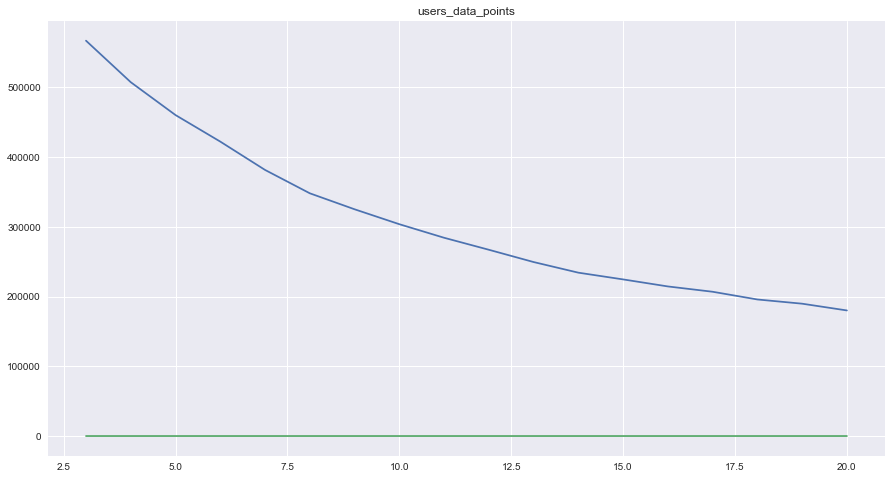

In [97]:
plot_kmeans_stats(reduced_data_points, 21, "users_data_points")

No "elbow" here either.

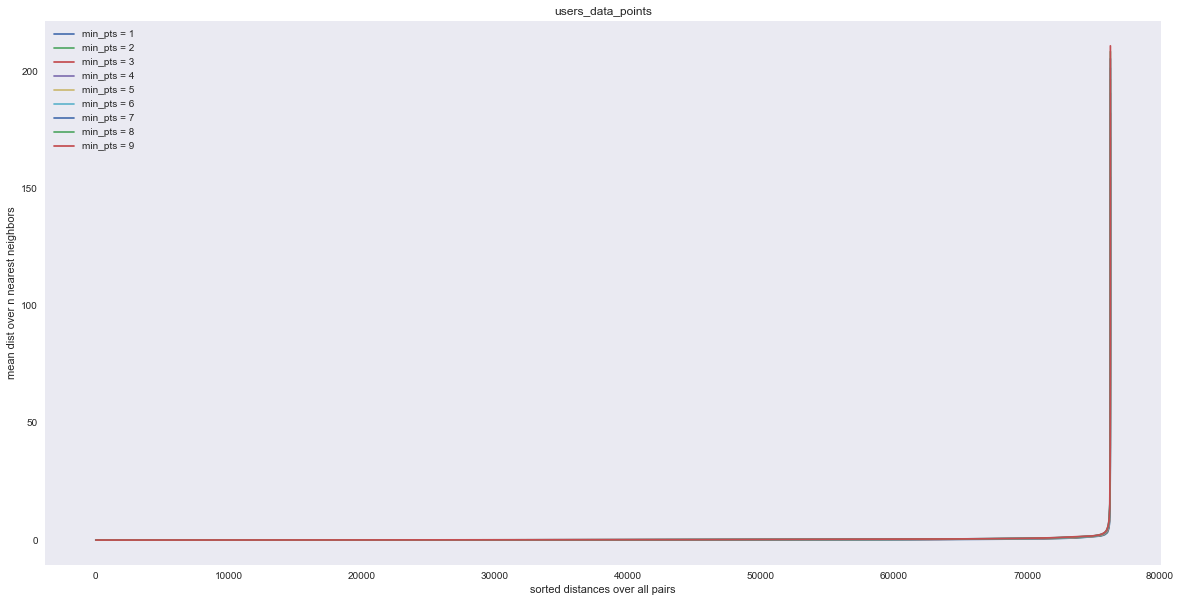

In [98]:
plot_elbow(data_points, "users_data_points")

*"Good luck guessing elbow here"*

And again, let's compare:

In [99]:
users_clusters_db = DBSCAN(eps=1.4, min_samples=4, n_jobs=-1).fit_predict(data_points)
Counter(users_clusters_db)

Counter({-1: 1818,
         0: 2424,
         1: 5816,
         2: 2825,
         3: 5081,
         4: 3661,
         5: 8116,
         6: 10133,
         7: 3392,
         8: 1388,
         9: 3363,
         10: 6027,
         11: 1224,
         12: 1802,
         13: 1915,
         14: 1478,
         15: 1090,
         16: 6341,
         17: 3451,
         18: 3645,
         19: 1162,
         20: 6,
         21: 5,
         22: 7,
         23: 4,
         24: 15,
         25: 4,
         26: 4,
         27: 6,
         28: 4,
         29: 12,
         30: 4,
         31: 10,
         32: 5,
         33: 4,
         34: 4,
         35: 4,
         36: 4,
         37: 4})

In [100]:
users_clusters_km = KMeans(random_state=0, init="k-means++", n_clusters=20).fit_predict(reduced_data_points)
Counter(users_clusters_km)

Counter({0: 21036,
         1: 3,
         2: 2048,
         3: 335,
         4: 43,
         5: 14905,
         6: 1,
         7: 1,
         8: 72,
         9: 508,
         10: 378,
         11: 5,
         12: 3956,
         13: 5,
         14: 5,
         15: 148,
         16: 1858,
         17: 28450,
         18: 44,
         19: 2457})

KMeans basically assigns 80% of users into 3 clusters, it just couldn't be true. 1-user clusters look not plausible too.

At this time DBSCAN (after some trial and error with hyperparams) manages to find more consistently-sized clusters.

In [101]:
users["user_c"] = users_clusters_db

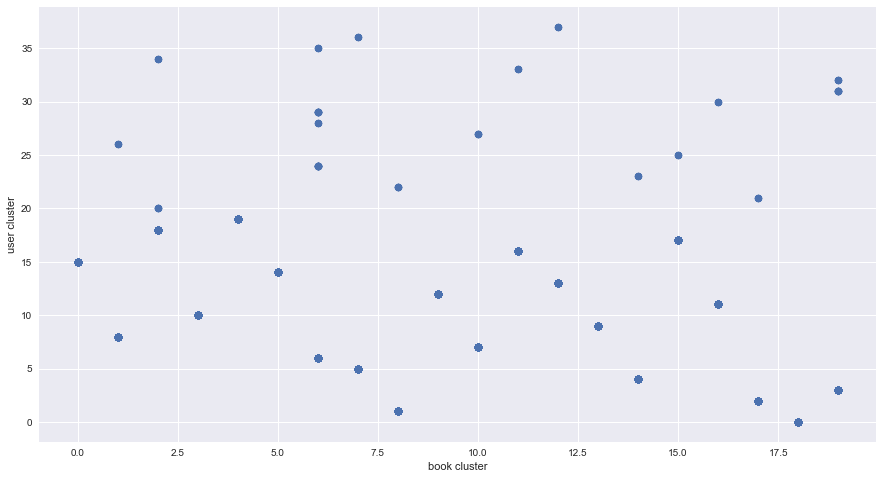

In [102]:
p = plt.scatter(users[users.user_c != -1].cluster, users[users.user_c != -1].user_c)
plt.xlabel("book cluster")
plt.ylabel("user cluster")
p

# 5. Проанализировать результат
получилось или нет, почему, что можно улучшить, можно ли интерпретировать результат

Loks like `cluster` feature, extracted from the books is a really big deal when it comes to clustering, because, if we remove noise (`cluster == -1`), classes of customers and books are quite aligned with each other and rarely share an axis.  
Maybe, each of these cases is, actually, a cluster, erroneously separated in two. Or, they are *actually* love the same books, but have a bit different behaviour patterns.

Result is pretty interpretable, if we join users `cluster` with unique names or, even better, with lemmatized unique names that  this cluster, we'll be able to predict whether custormer will like an arbitrary book or not.

# 6. Повторить при необходимости 

# Подсказки

* Проводить EDA и работу с признаками на всем датасете
* Для построения модели отсеивать данные тем или иным способом (обосновать выбор) - уменьшить объем данных для анализа
* Оформлять для сдачи задания все эксперименты (в том числе неудачные). Так мы сможем увидеть процесс работы над заданием
* Не тратить 90% времени на первый этап. Планировать время так, чтобы успеть поработать над моделью (в равной степени над каждым пунктом).